In [2]:
import os
os.chdir('/cluster/home/bdayan/girgs/benji_src/notebooks/')

In [3]:
import sys
sys.path.append('../')
sys.path.append('../../nemo-eva/src/')

import os
os.getcwd()



'/cluster/home/bdayan/girgs/benji_src/notebooks'

In [4]:
from benji_girgs import utils, generation, points, fitting, mcmc
import os
import glob
import pandas as pd
import networkit

import networkit as nk

from girg_sampling import girgs

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import matplotlib.pyplot as plt

import do_feature_extract
import networkx as nx


/cluster/scratch/bdayan/GIRG_data/socfb-Caltech36.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Reed98.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Haverford76.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Simmons81.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Swarthmore42.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Amherst41.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Bowdoin47.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Hamilton46.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Trinity100.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-USFCA72.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Williams40.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Oberlin44.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Wellesley22.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Smith60.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Vassar85.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Middlebury45.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Pepperdine8

In [4]:
%matplotlib notebook

In [9]:
import importlib
importlib.reload(generation)
importlib.reload(fitting)

CPU times: user 42.8 ms, sys: 11 ms, total: 53.8 ms
Wall time: 52.2 ms


array([[0.        , 0.37284425, 0.58050998, ..., 0.75874127, 0.18234182,
        0.60228748],
       [0.37284425, 0.        , 0.29831461, ..., 0.65973309, 0.55518607,
        0.32009212],
       [0.58050998, 0.29831461, 0.        , ..., 0.6990982 , 0.59455117,
        0.23199064],
       ...,
       [0.75874127, 0.65973309, 0.6990982 , ..., 0.        , 0.64808346,
        0.46710756],
       [0.18234182, 0.55518607, 0.59455117, ..., 0.64808346, 0.        ,
        0.49162968],
       [0.60228748, 0.32009212, 0.23199064, ..., 0.46710756, 0.49162968,
        0.        ]])

In [14]:
b = 2.0
n = 1500
d = 1
tau = 2.1
alpha=1.2
desiredAvgDegree=100.0

g, edges, weights, pts, const = generation.generate_GIRG_nk(n, d, tau, alpha, desiredAvgDegree=desiredAvgDegree, points_type=points.PointsCube)
nk.overview(g)

gnx = nk.nxadapter.nk2nx(g)
A = nx.adjacency_matrix(gnx).todense()

const_in = generation.const_conversion(const, alpha, d, true_volume=True)
p_uv = generation.get_probs(weights / np.sqrt(weights.sum()), pts, alpha, const_in)

In [15]:
def girg_loglikelihood(A, p_uv):
    """
        A: adjacency matrix nxn
        p_uv: probability matrix

    Returns:

    """
    A_bar = -A + 1
    # no self loops
    np.fill_diagonal(A, 0)
    np.fill_diagonal(A_bar, 0)

    # this is all very painful, maybe we can just clip p_uv not to be 0 or 1
    eps = 1e-7
    p_uv = np.clip(p_uv, eps, 1 - eps)

    # self.p_uv has some 0s and 1s, so np.log gives some -inf. We
    # do nan_to_num which makes -inf -> large negative number, s.t.
    # A_ij * ?_ij is 0 and not nan when previously ?_ij was -inf.

    # of course if A_ij is not 0, i.e. we have an edge, yet still
    # self.p_uv is 0, we -ve large, and log_likelihood will be
    # -inf probably. :(
    log_likelihood = np.sum(
        A * np.nan_to_num((np.log(p_uv))) +
        A_bar * np.nan_to_num((np.log(1 - p_uv)))
    )

    return log_likelihood

54.1 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
gnx = nk.nxadapter.nk2nx(g)
A = nx.adjacency_matrix(gnx).todense()

const_in = generation.const_conversion(const, alpha, d, true_volume=True)
p_uv = generation.get_probs(weights / np.sqrt(weights.sum()), pts, alpha, const_in)

54 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [224]:
fitting.girg_loglikelihood(A, p_uv)

PointsTorus2(-215374.1472412)

In [225]:
pts_init = points.PointsTorus2(np.random.uniform(size=(n, d)))
fitting.girg_loglikelihood(A, generation.get_probs(weights / np.sqrt(weights.sum()), pts_init, alpha, const_in))

PointsTorus2(-912635.16100014)

In [121]:
pts_temp = pts.copy()
pts_temp[0] = [0.5, 0.5]
# for i in range(len(pts_temp)):
#     for j in range(d):
#         pts_temp[i][j] = max(min(0, pts_temp[i][j] + np.random.normal(0, 0.1)), 1)

p_uv_temp = generation.get_probs(weights / np.sqrt(weights.sum()), pts_temp, alpha, const_in)

# much lower :)
fitting.girg_loglikelihood(A, p_uv_temp)

PointsTorus2(-219362.80161586)

In [161]:
x = pts_temp[0].copy()
pts_temp[0] = [0.5, 0.9]

In [162]:
pts_temp
x

PointsTorus2([[0.5       , 0.9       ],
              [0.21699159, 0.83268538],
              [0.13882835, 0.78394861],
              ...,
              [0.57569804, 0.53633296],
              [0.36602612, 0.23769918],
              [0.91996682, 0.32568104]])

PointsTorus2([0.5, 0.5])

In [103]:
pts_temp

PointsTorus2([[1., 1.],
              [1., 1.],
              [1., 1.],
              ...,
              [1., 1.],
              [1., 1.],
              [1., 1.]])

In [151]:
u_index = 0
p_u_to_v = generation.get_probs_u(weights / np.sqrt(weights.sum()), pts, alpha, const_in, u_index)
eps = 1e-7
p_u_to_v = np.clip(p_u_to_v, eps, 1-eps)
# np.log(p_u_to_v[1:]).sum()

p_u_to_v2 = generation.get_probs_u(weights / np.sqrt(weights.sum()), pts_temp, alpha, const_in, u_index)
p_u_to_v2 = np.clip(p_u_to_v2, eps, 1-eps)
# np.log(p_u_to_v2[1:]).sum()


../benji_girgs/generation.py:78: RuntimeWarning: divide by zero encountered in true_divide
  p_uv = np.power(p_uv, alpha)


In [167]:
mask = np.ones(n, dtype=bool)
mask[u_index] = False
log_Q_u = A[u_index, mask] * np.log(p_u_to_v[mask]) + (1 - A[u_index, mask]) * np.log(1 - p_u_to_v[mask])
log_Q_u2 = A[u_index, mask] * np.log(p_u_to_v2[mask]) + (1 - A[u_index, mask]) * np.log(1 - p_u_to_v2[mask])

Q_ratio = np.exp(log_Q_u2.sum() - log_Q_u.sum())
acceptance_prob = np.minimum(1, Q_ratio)

In [168]:
log_Q_u.sum()
# is much more negative :)
log_Q_u2.sum()

PointsTorus2(-78.66932437)

PointsTorus2(-206.77136187)

In [169]:
acceptance_prob

PointsTorus2(2.32269397e-56)

In [153]:
np.argwhere(p_u_to_v == 1)

array([], shape=(0, 1), dtype=int64)

In [ ]:
mask = np.ones(n, dtype=bool)
mask[u_index] = False
log_Q_u = A[u_index, mask] * np.log(p_u_to_v[mask]) + (1 - A[u_index, mask]) * np.log(1 - p_u_to_v[mask])
log_Q_u2 = A[u_index, mask] * np.log(p_u_to_v2[mask]) + (1 - A[u_index, mask]) * np.log(1 - p_u_to_v2[mask])

In [146]:
np.argwhere(p_u_to_v == 0)

array([], shape=(0, 1), dtype=int64)

In [154]:
(log_Q_u > log_Q_u2).sum()

PointsTorus2(787)

# MCMC run attempt

In [256]:
pts_init = points.PointsTorus2(np.random.uniform(size=(n, d)))

pts_init2 = pts_init.copy()
pts_final, lls, num_acceptances = fitting.mcmc_girg(A, weights, alpha, d, const, pts_init, n_steps=20)

  0%|          | 0/20 [00:00<?, ?it/s]../benji_girgs/generation.py:78: RuntimeWarning: divide by zero encountered in true_divide
  p_uv = np.divide(wuwv, dists**d)
100%|██████████| 20/20 [00:03<00:00,  5.04it/s]


In [45]:
import importlib
importlib.reload(generation)
importlib.reload(fitting)
importlib.reload(points)

<module 'benji_girgs.generation' from '../benji_girgs/generation.py'>

<module 'benji_girgs.fitting' from '../benji_girgs/fitting.py'>

../benji_girgs/points.py:190: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (n, d == other.shape)


<module 'benji_girgs.points' from '../benji_girgs/points.py'>

In [18]:
%matplotlib notebook

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

<IPython.core.display.Javascript object>

In [4]:
# %matplotlib notebook
# pts_init = points.PointsTorus2(np.random.uniform(size=(n, d)))

pts_init = pts.copy()
pts_final, lls, num_acceptances = fitting.mcmc_girg(A, weights, alpha, d, const, pts_init, n_steps=500, plot_every=10)

NameError: name 'plt' is not defined

# Diffusion Map

In [181]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

<IPython.core.display.Javascript object>

In [182]:
mcmc.run(8000, plot_every=50)

 13%|█▎        | 1050/8000 [00:04<00:31, 222.66it/s]../benji_girgs/fitting.py:650: RuntimeWarning: overflow encountered in exp
  Q_ratio = np.exp(u_ll_new - u_ll_old)
100%|██████████| 8000/8000 [00:36<00:00, 218.82it/s]


In [184]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

<IPython.core.display.Javascript object>

In [185]:
mcmc.run(50000, plot_every=50)

100%|██████████| 50000/50000 [03:36<00:00, 230.57it/s]


In [37]:

u_index = 0

eps = 1e-7
p_u_to_vs = generation.get_probs_u(self.weights, self.pts, self.alpha, self.const_in, u_index)
p_u_to_vs = np.clip(p_u_to_vs, eps, 1 - eps)
u_ll = self.p_u_to_vs_to_ll(u_index, p_u_to_vs)


In [38]:
u_ll

-12722.112609032372

In [39]:
self = mcmc
outs = []
outs2 = []
for u in range(self.n):
    eps = 1e-7
    p_u_to_vs = generation.get_probs_u(self.weights, self.pts, self.alpha, self.const_in, u_index)
    p_u_to_vs = np.clip(p_u_to_vs, eps, 1 - eps)
    u_ll = self.p_u_to_vs_to_ll(u_index, p_u_to_vs)
    outs.append(p_u_to_vs.sum())
    outs2.append(u_ll)

In [44]:
np.sqrt(100*1500)

387.2983346207417

In [42]:
mcmc.weights

array([0.29466799, 2.52075074, 0.1821584 , ..., 0.28931039, 0.24377079,
       0.1687644 ])

In [104]:
import importlib
importlib.reload(fitting)
importlib.reload(mcmc)

<module 'benji_girgs.fitting' from '../benji_girgs/fitting.py'>

<module 'benji_girgs.mcmc' from '../benji_girgs/mcmc.py'>

In [105]:
n = 1500
d = 2
tau = 2.1
alpha = 1.2
desiredAvgDegree = 100.0

# This const was generated for the power law distribution
g, edges, weights, pts, const = generation.generate_GIRG_nk(n, d, tau, alpha, desiredAvgDegree=desiredAvgDegree,points_type=points.PointsCube)

weights = np.array(utils.graph_degrees_to_weights(g))
const2 = girgs.scaleWeights(weights, desiredAvgDegree, d, alpha)

# TODO why are const and const2 quite different?


print('diffmapping')
w, Phi, Psi, diff_map = utils.get_diffmap(g, Iweighting=0.5, eye_or_ones='eye')
print('extracting diffmaps')
pts_diffmap = np.array([diff_map(i, 10) for i in range(n)])
pts_diffmap = points.normalise_points_to_cube(pts_diffmap[:, 0:1])
pts_diffmap = points.PointsCube(pts_diffmap)

pts_init = points.PointsCube(np.random.uniform(size=(n,1)))

print('initialising mcmc')
mcmc_base = mcmc.MCMC_girg(g, weights, alpha, const2, pts_diffmap, pool=False)
mcmc_pool = mcmc.MCMC_girg(g, weights, alpha, const2, pts_diffmap.copy(), pool=True)

# mcmc_cheat = mcmc.MCMC_girg(g, weights, alpha, const2, pts)
# mcmc_diffmap = mcmc.MCMC_girg(g, weights, alpha, const2, pts_diffmap.copy())
# mcmc_cheat.ll
# mcmc_diffmap.ll

const_in: 28.534358570463834
diffmapping
extracting diffmaps
initialising mcmc


100%|██████████| 2000/2000 [00:10<00:00, 188.94it/s]


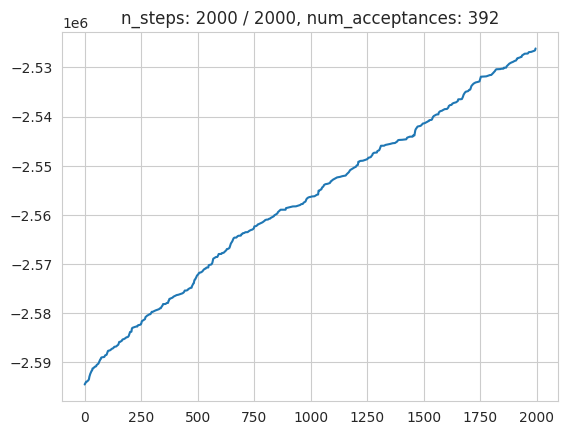

In [31]:
mcmc_base.run(2000, plot_every=20, pool_size=None)

100%|██████████| 2000/2000 [00:15<00:00, 125.26it/s]


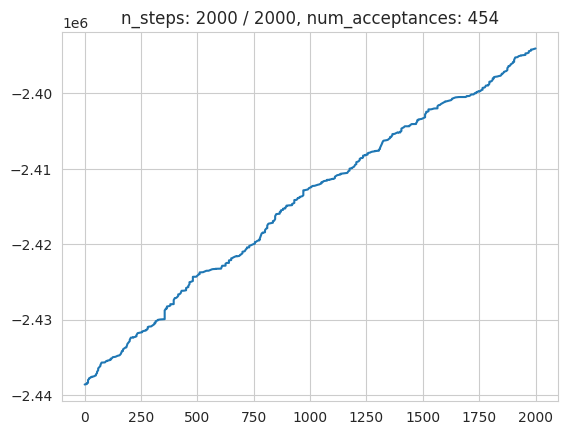

In [36]:
mcmc_pool.run(2000, pool_size=5, jobs_per_worker=1, plot_every=20)

100%|██████████| 2000/2000 [00:05<00:00, 351.39it/s]


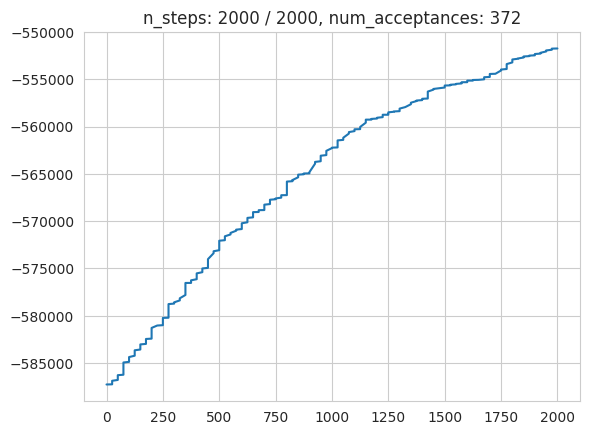

In [78]:
mcmc_pool = mcmc.MCMC_girg(g, weights, alpha, const2, pts_diffmap.copy(), pool=True)
mcmc_pool.run(2000, pool_size=5, jobs_per_worker=5, plot_every=20)
mcmc_pool.plot_ll(2000)

2023it [00:05, 354.10it/s]                          


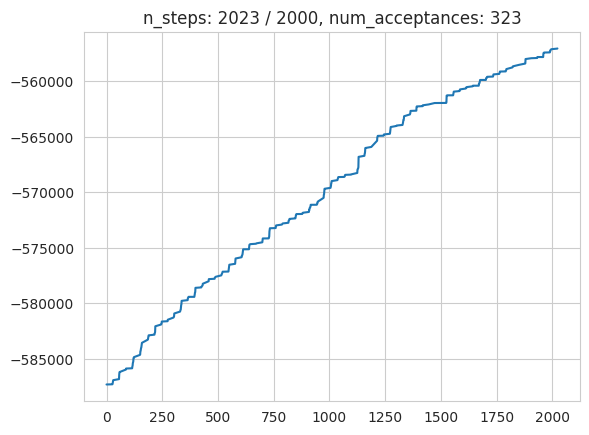

In [77]:
mcmc_pool = mcmc.MCMC_girg(g, weights, alpha, const2, pts_diffmap.copy(), pool=True)
mcmc_pool.run_pool(2000, pool_size=5, jobs_per_worker=5, plot_every=20)
mcmc_pool.plot_ll(2000)

2025it [00:05, 386.26it/s]                          


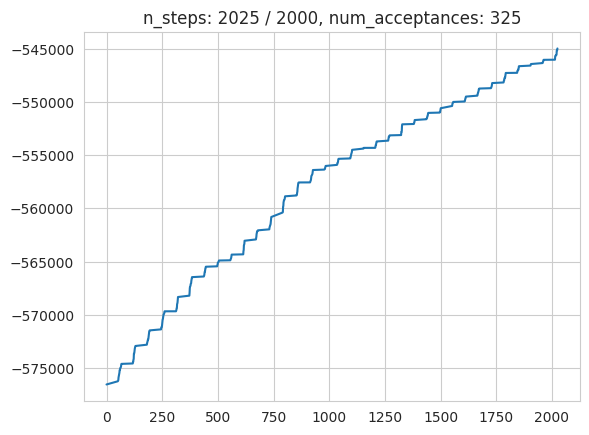

In [106]:
mcmc_pool = mcmc.MCMC_girg(g, weights, alpha, const2, pts_diffmap.copy(), pool=True)
mcmc_pool.run_pool(2000, pool_size=10, jobs_per_worker=5, plot_every=20)
mcmc_pool.plot_ll(2000)

2611it [00:07, 328.41it/s]                          


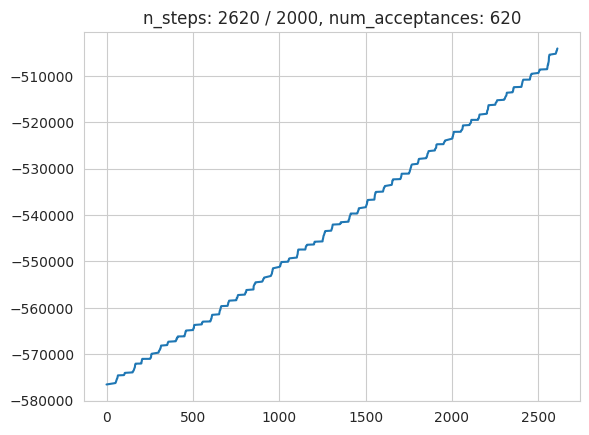

In [107]:
mcmc_pool = mcmc.MCMC_girg(g, weights, alpha, const2, pts_diffmap.copy(), pool=True)
mcmc_pool.run_pool2(2000, pool_size=10, jobs_per_worker=5, plot_every=20)
mcmc_pool.plot_ll(2000)

In [65]:
mcmc_pool.pts = points.PointsCube(np.arange(2000))
%timeit mcmc_pool.pts.copy()

1.17 µs ± 1.44 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [64]:
temp = np.arange(2000)
%timeit temp.copy()

1.04 µs ± 2.71 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [51]:
a = mcmc_pool.pts.copy()
a[0] = 2.5
mcmc_pool.pts[0]

PointsCube([0.89791126])

PointsCube([2.5])

In [36]:
mcmc_pool.lls

[-365943.035479955,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.08597674704,
 -365909.085

In [29]:
mcmc.lls

[-351197.5049490849,
 -351077.6551059935,
 -350993.8681370363,
 -350894.61058125173,
 -350655.3529522418,
 -350632.777813372,
 -350556.30811646977,
 -350394.3588502556,
 -350183.98386815697,
 -350162.69728100294,
 -350095.99861182587,
 -349961.7975622979,
 -349719.3461985899,
 -349669.95399128617,
 -349365.43074143515,
 -349068.7120378346,
 -349060.21927635255,
 -348957.80620855646,
 -348933.26729518914,
 -348922.1245933784,
 -348785.475361725,
 -348631.78922145773,
 -348411.4217270581,
 -348357.6169689055,
 -348035.8927887334,
 -347738.47832689295,
 -347735.91990565154,
 -347611.49269329465,
 -347440.88987150346,
 -347392.0869036893,
 -347384.65797139495,
 -347354.380292258,
 -347271.47277434013,
 -347234.95173304505,
 -347178.7734072432,
 -347110.35664886044,
 -346803.51540192106,
 -346524.6001927832,
 -346506.6263830852,
 -346476.8582701168,
 -346447.6556177442,
 -346361.1336206847,
 -346352.2557207494,
 -346339.4623695285,
 -346307.2097213847,
 -346263.423525216,
 -346260.324662226

In [146]:
mcmc.shared_pts = multiprocessing.Array(ctypes.c_double, int(np.prod(mcmc.pts.shape)))

AttributeError: 'c_double_Array_1000' object has no attribute 'shape'

In [155]:
mcmc.pts

In [164]:
mcmc.step_pool(pool_size=5)

684
[0.59284462]
5.512609727724017e-38
accepted: False
37
[0.99718481]
1
accepted: True


In [129]:
mcmc.shared_pts

In [107]:
acceptance_prob, u_index, x_u2, u_ll_old, u_ll_new, p_u_to_vs_old, p_u_to_vs_new = mcmc.step0()
print(u_index)
print(x_u2)
print(acceptance_prob)

994
[0.53138634]
3.744124939202854e-139


In [100]:
u_index

240

100%|██████████| 5000/5000 [00:27<00:00, 182.18it/s]


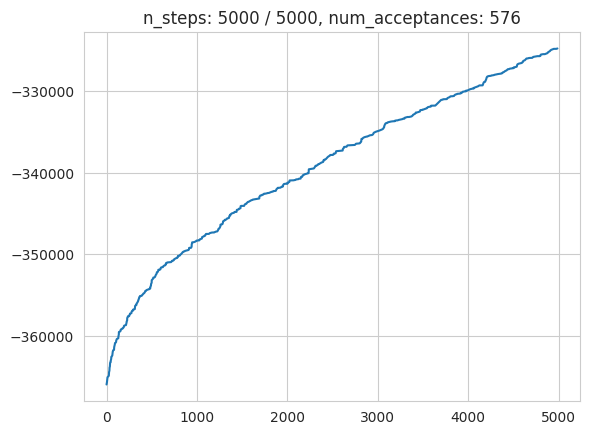

In [55]:
mcmc.run(n_steps=5000, plot_every=20)

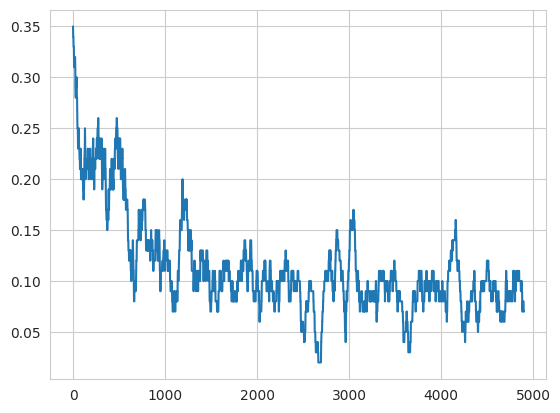

In [56]:
# running average of mean acceptance rate
acceptances = np.zeros(mcmc.num_steps)
for step in mcmc.ll_steps:
    acceptances[step] = 1
plt.plot(np.convolve(acceptances, np.ones(100)/100, mode='valid'))

(array([36., 29., 35., 21., 23., 22., 18., 25., 20., 30.]),
 array([   0. ,  149.6,  299.2,  448.8,  598.4,  748. ,  897.6, 1047.2,
        1196.8, 1346.4, 1496. ]),
 <BarContainer object of 10 artists>)

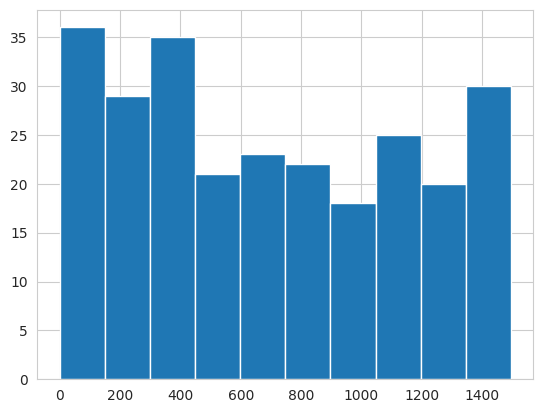

In [53]:
plt.hist(mcmc.ll_steps)

In [32]:
import multiprocessing
import ctypes
a = multiprocessing.RawArray(ctypes.c_double, 100*2)
b = np.ndarray((100, 2), dtype=np.float64, buffer=a)

In [41]:
# product of numpy array's shape
type(np.prod(b.shape))

numpy.int64

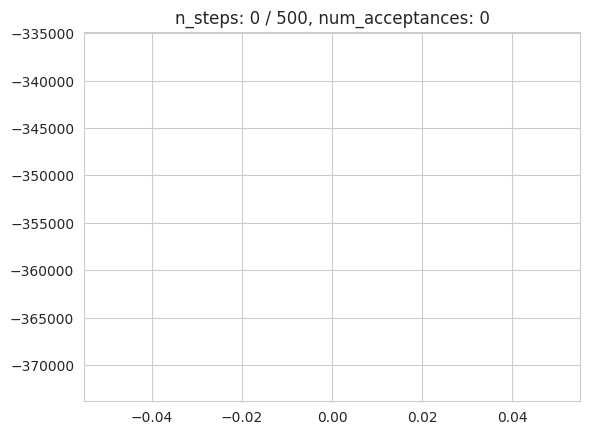

In [20]:
mcmc.run_pool(n_steps=500, plot=True)

100%|██████████| 1500/1500 [00:08<00:00, 182.12it/s]


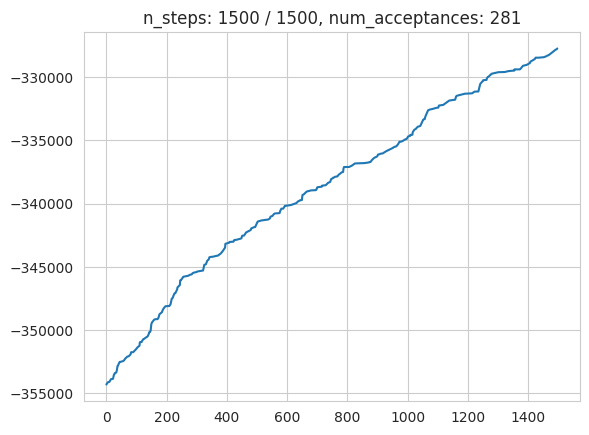

In [22]:
mcmc.run(1500, plot_every=20)

In [10]:
mcmc.run_pool(n_steps=500, plot=True)

AttributeError: 'NoneType' object has no attribute 'map'

In [205]:
np.corrcoef(mcmc_diffmap.pts[:, 0], pts[:, 0])
np.corrcoef(mcmc.pts[:, 0], pts[:, 0])

array([[ 1.        , -0.98046394],
       [-0.98046394,  1.        ]])

array([[ 1.        , -0.90012141],
       [-0.90012141,  1.        ]])

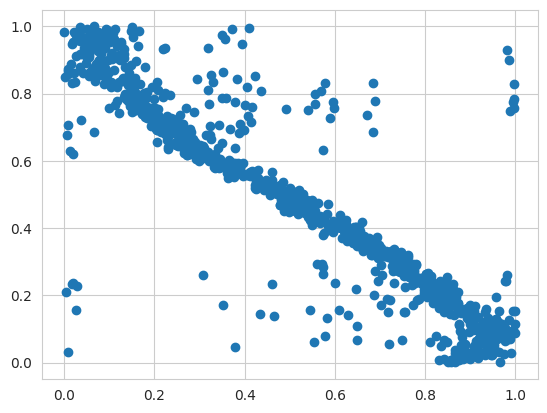

In [206]:
plt.scatter(mcmc.pts[:, 0], pts[:, 0])

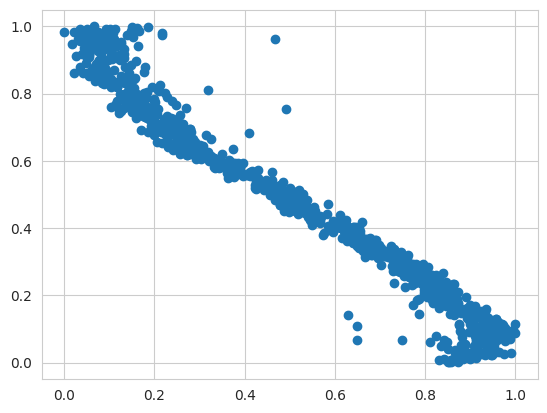

In [207]:
plt.scatter(mcmc_diffmap.pts[:, 0], pts[:, 0])

In [210]:
changed = mcmc.pts.squeeze() != mcmc_diffmap.pts.squeeze()
changed.sum()
mcmc.num_acceptances
# TODO WTF why are these two numbers different?

PointsCube(170)

194

(array([  1.,   0.,   1.,   6.,  54., 393., 361., 175.,   6.,   3.]),
 array([-0.4292676 , -0.35806983, -0.28687206, -0.21567429, -0.14447652,
        -0.07327875, -0.00208098,  0.06911679,  0.14031456,  0.21151233,
         0.2827101 ]),
 <BarContainer object of 10 artists>)

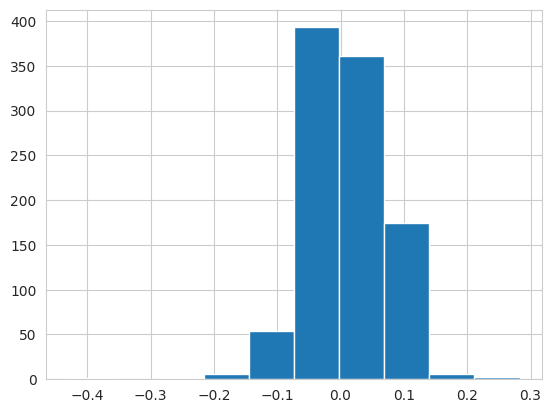

In [213]:
plt.hist((1- mcmc_diffmap.pts) - pts)

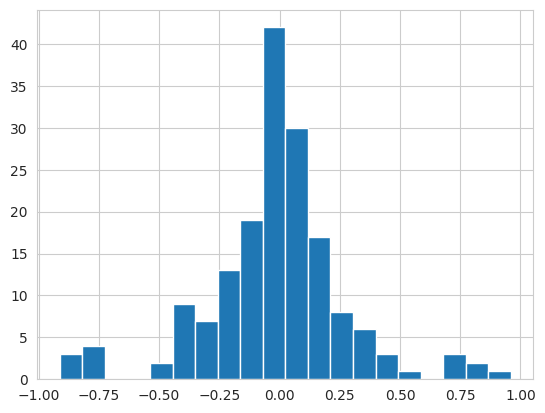

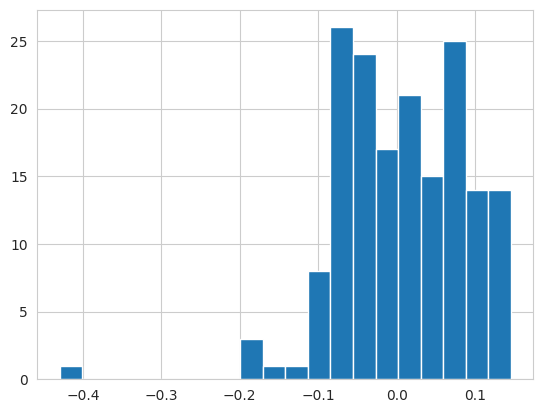

In [216]:
a = (1 - mcmc.pts[changed]) - pts[changed]
b = (1 - mcmc_diffmap.pts[changed]) - pts[changed]
_ = plt.figure()
_ = plt.hist(a, bins=20)
_ = plt.figure()
_ = plt.hist(b, bins=20)

  0%|          | 0/5000 [00:00<?, ?it/s]../benji_girgs/generation.py:78: RuntimeWarning: divide by zero encountered in true_divide
  p_uv = np.divide(wuwv, dists**d)
100%|██████████| 5000/5000 [00:28<00:00, 177.45it/s]


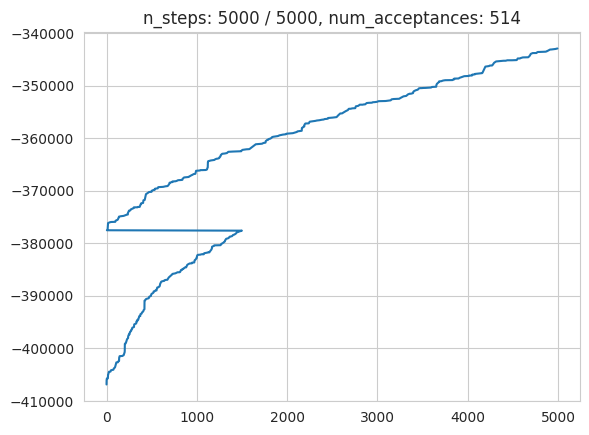

In [217]:
mcmc.run(n_steps=5000, plot_every=20)

In [218]:
changed = mcmc.pts.squeeze() != mcmc_diffmap.pts.squeeze()
changed.sum()
mcmc.num_acceptances
# TODO WTF why are these two numbers different?

PointsCube(363)

514

In [220]:
np.corrcoef(mcmc_diffmap.pts[:, 0], pts[:, 0])
np.corrcoef(mcmc.pts[:, 0], pts[:, 0])

array([[ 1.        , -0.98046394],
       [-0.98046394,  1.        ]])

array([[ 1.        , -0.95272741],
       [-0.95272741,  1.        ]])

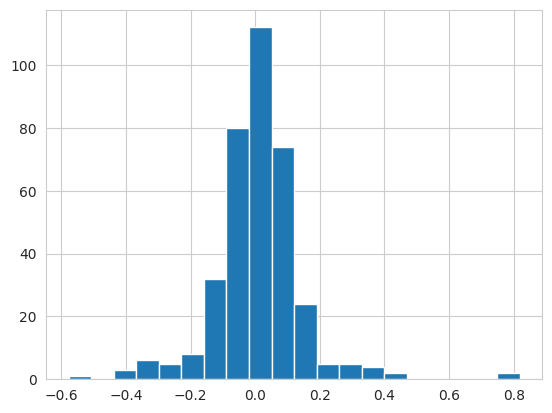

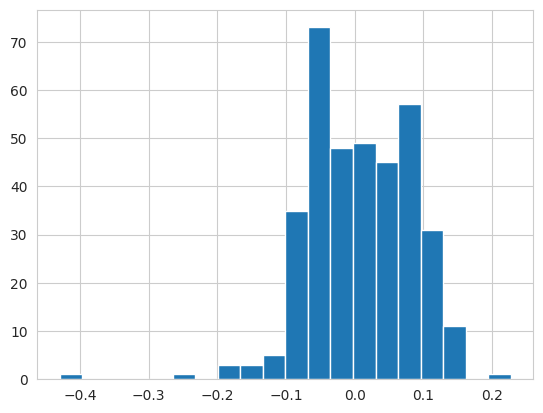

In [221]:
a = (1 - mcmc.pts[changed]) - pts[changed]
b = (1 - mcmc_diffmap.pts[changed]) - pts[changed]
_ = plt.figure()
_ = plt.hist(a, bins=20)
_ = plt.figure()
_ = plt.hist(b, bins=20)

  0%|          | 0/8000 [00:00<?, ?it/s]../benji_girgs/generation.py:78: RuntimeWarning: divide by zero encountered in true_divide
  p_uv = np.divide(wuwv, dists**d)
100%|██████████| 8000/8000 [00:45<00:00, 175.20it/s]


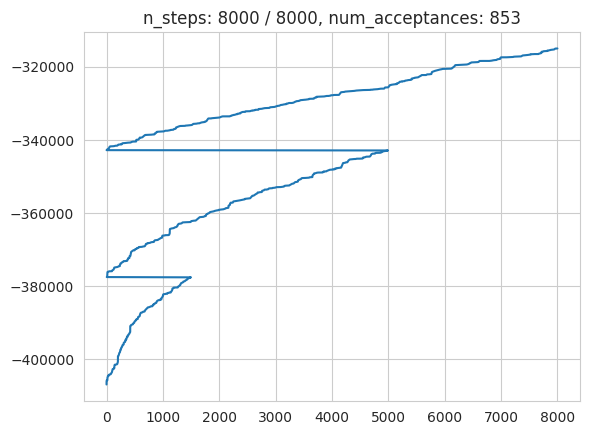

In [222]:
mcmc.run(n_steps=8000, plot_every=20)

In [223]:
np.corrcoef(mcmc_diffmap.pts[:, 0], pts[:, 0])
np.corrcoef(mcmc.pts[:, 0], pts[:, 0])

array([[ 1.        , -0.98046394],
       [-0.98046394,  1.        ]])

array([[ 1.        , -0.97170376],
       [-0.97170376,  1.        ]])

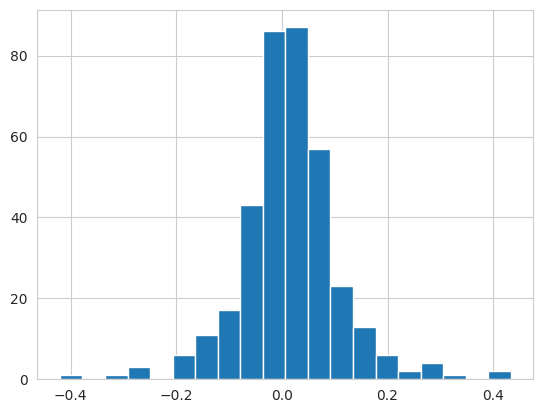

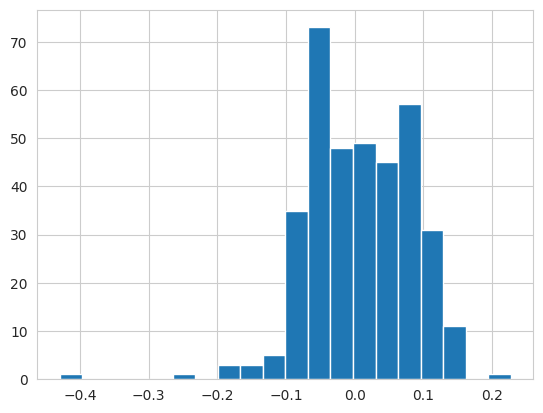

In [224]:
a = (1 - mcmc.pts[changed]) - pts[changed]
b = (1 - mcmc_diffmap.pts[changed]) - pts[changed]
_ = plt.figure()
_ = plt.hist(a, bins=20)
_ = plt.figure()
_ = plt.hist(b, bins=20)

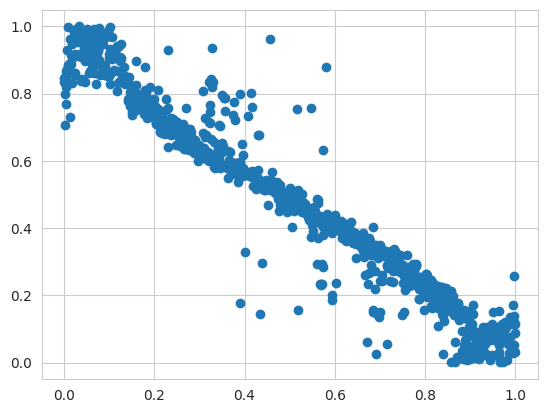

In [225]:
plt.scatter(mcmc.pts[:, 0], pts[:, 0])

In [192]:
w, Phi, Psi, diff_map = utils.get_diffmap(g, Iweighting=0.5, eye_or_ones='eye')
print('extracting diffmaps')
pts_diffmap = np.array([diff_map(i, 10) for i in range(n)])
pts_diffmap = points.normalise_points_to_cube(pts_diffmap[:, 0:1])
pts_diffmap = points.PointsCube(pts_diffmap)

extracting diffmaps


In [194]:
np.corrcoef(pts_diffmap[:, 0], pts[:, 0])
np.corrcoef(mcmc.pts[:, 0], pts[:, 0])

array([[1.       , 0.9863455],
       [0.9863455, 1.       ]])

array([[1.        , 0.87737384],
       [0.87737384, 1.        ]])

In [106]:
%time g, edges, weights, pts, const = generation.generate_GIRG_nk(n, d, tau, alpha, desiredAvgDegree=desiredAvgDegree,points_type=points.PointsCube)

const_in: 10.638921092570195
CPU times: user 3.68 s, sys: 578 ms, total: 4.26 s
Wall time: 4.26 s


In [107]:
%time w, Phi, Psi, diff_map = utils.get_diffmap(g, Iweighting=0.5, eye_or_ones='eye')

CPU times: user 48.9 s, sys: 1.06 s, total: 50 s
Wall time: 50.1 s


In [152]:
gnx = nk.nxadapter.nk2nx(g)

In [110]:
A = nx.linalg.adjacency_matrix(gnx)

In [131]:
D = np.array([x[1] for x in (gnx.degree)])
D_h = D**(0.5)
D_hi = D**(-0.5)

n = A.shape[0]

In [136]:
# M = np.diag(1/D) @ A
M = (A.T).multiply(1/D).T

In [134]:
Iweighting=0.5
eye_or_ones='eye'
M = (1 - Iweighting) * M + Iweighting * (np.ones((n, n))/n if eye_or_ones == "ones" else np.eye(n))

In [140]:
import scipy
(1 - Iweighting) * M + scipy.sparse.eye(n) * Iweighting

<5000x5000 sparse array of type '<class 'numpy.float64'>'
	with 475362 stored elements in Compressed Sparse Row format>

In [142]:
scipy.sparse.diags(np.arange(4)).todense()

matrix([[0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 2., 0.],
        [0., 0., 0., 3.]])

In [173]:
A = nx.linalg.adjacency_matrix(gnx)

D = np.array([x[1] for x in (gnx.degree)])
D_h = D**(0.5)
D_hi = D**(-0.5)

n = A.shape[0]

# M_ij = W_ij / d_i
# M = np.diag(1/D) @ A
# sparse array version
M = scipy.sparse.diags(1/D) @ A

# M = (1-Iweighting)* M + Iweighting * np.eye(M.shape[0])
# M = (1 - Iweighting) * M + Iweighting * (np.ones((n, n))/n if eye_or_ones == "ones" else np.eye(n))
# sparse array version
M = (1 - Iweighting) * M + scipy.sparse.eye(n) * Iweighting

# S_ij = W_ij / sqrt(d_i d_j) = sqrt(d_i) M_ij / sqrt(d_j)
# S = np.diag(D_h) @ M @ np.diag(D_hi)
# sparse array version
S = scipy.sparse.diags(D_h) @ M @ scipy.sparse.diags(D_hi)

# w, V = np.linalg.eigh(S)
# sparse array version
w, V = scipy.sparse.linalg.eigsh(S, k=5, which="LM")

In [149]:
w

array([0.81058687, 0.82713466, 0.85580873, 0.90250275, 1.        ])

In [174]:
A = nx.linalg.adjacency_matrix(gnx)

D = np.array([x[1] for x in (gnx.degree)])
D_h = D**(0.5)
D_hi = D**(-0.5)

n = A.shape[0]

# M_ij = W_ij / d_i
M = np.diag(1/D) @ A
# sparse array version
# M = (A.T).multiply(1/D).T

# M = (1-Iweighting)* M + Iweighting * np.eye(M.shape[0])
M = (1 - Iweighting) * M + Iweighting * (np.ones((n, n))/n if eye_or_ones == "ones" else np.eye(n))
# sparse array version
# M = (1 - Iweighting) * M + scipy.sparse.eye(n) * Iweighting

# S_ij = W_ij / sqrt(d_i d_j) = sqrt(d_i) M_ij / sqrt(d_j)
S = np.diag(D_h) @ M @ np.diag(D_hi)
# sparse array version
# S = scipy.sparse.diags(D_h) @ M @ scipy.sparse.diags(D_hi)

w2, V2 = np.linalg.eigh(S)
# sparse array version
# w, V = scipy.sparse.linalg.eigsh(S, k=n-1, which="LM")

In [161]:
w2[-1:-8:-1]
w[-1:-8:-1]

array([1.        , 0.8411403 , 0.79253683, 0.75194304, 0.72480366,
       0.70712106, 0.69661123])

array([1.        , 0.8411403 , 0.79253683, 0.75194304, 0.72480366])

In [175]:
V[:, -1:-8:-1]
V2[:, -1:-8:-1]

array([[-0.0259028 ,  0.00714571, -0.02108837, -0.03614142,  0.00370199],
       [-0.02213377,  0.01041828, -0.01610386, -0.04160505,  0.00726822],
       [-0.02353305,  0.01533918, -0.01561307, -0.03842203,  0.00679737],
       ...,
       [-0.02213377, -0.00186499, -0.0284924 , -0.01109445, -0.03878234],
       [-0.02651236,  0.01567722, -0.016977  , -0.06013824,  0.01956825],
       [-0.03008749, -0.00621539, -0.04093346, -0.00450382, -0.05164334]])

array([[-0.0259028 , -0.00714571,  0.02108837, ...,  0.00370199,
        -0.02700494,  0.04387078],
       [-0.02213377, -0.01041828,  0.01610386, ...,  0.00726822,
        -0.02417404,  0.04898298],
       [-0.02353305, -0.01533918,  0.01561307, ...,  0.00679737,
        -0.02096487,  0.04119823],
       ...,
       [-0.02213377,  0.00186499,  0.0284924 , ..., -0.03878234,
        -0.02800089, -0.02736041],
       [-0.02651236, -0.01567722,  0.016977  , ...,  0.01956825,
        -0.02577367,  0.06471714],
       [-0.03008749,  0.00621539,  0.04093346, ..., -0.05164334,
        -0.01649256, -0.04293208]])

In [166]:
V[:, -2::-1]

array([[ 0.00714571, -0.02108837, -0.03614142,  0.00370199],
       [ 0.01041828, -0.01610386, -0.04160505,  0.00726822],
       [ 0.01533918, -0.01561307, -0.03842203,  0.00679737],
       ...,
       [-0.00186499, -0.0284924 , -0.01109445, -0.03878234],
       [ 0.01567722, -0.016977  , -0.06013824,  0.01956825],
       [-0.00621539, -0.04093346, -0.00450382, -0.05164334]])

In [172]:
np.array([np.array([V[i, j] for j in range(-2, -6, -1 )]) for i in range(1000)]).shape

(1000, 4)

In [129]:
np.all((A.T).multiply(1/D).T.todense() == M)

True

In [130]:
np.all(A.multiply(1/D).todense() == M)

False

In [112]:
Iweighting=0.5
eye_or_ones='eye'

M = (1 - Iweighting) * M + Iweighting * (np.ones((n, n))/n if eye_or_ones == "ones" else np.eye(n))
# S_ij = W_ij / sqrt(d_i d_j) = sqrt(d_i) M_ij / sqrt(d_j)
S = np.diag(D_h) @ M @ np.diag(D_hi)

NameError: name 'Iweighting' is not defined

In [115]:
D

array([ 21, 425,  46, ...,  28,  47, 100])

In [91]:
self = mcmc

out = []
for u_index in range(self.n):
    eps = 1e-7
    p_u_to_vs = generation.get_probs_u(self.weights, self.pts, self.alpha, self.const_in, u_index)
    p_u_to_vs = np.clip(p_u_to_vs, eps, 1 - eps)
    u_ll = self.p_u_to_vs_to_ll(u_index, p_u_to_vs)
    self.ll += u_ll
    out.append(p_u_to_vs.sum())

np.sum(out)
100*1500

152454.76302647515

150000

In [23]:
w, Phi, Psi, diff_map = utils.get_diffmap(g, Iweighting=0.5, eye_or_ones='eye')

pts_diffmap = np.array([diff_map(i, 5) for i in range(n)])
pts_diffmap = points.normalise_points_to_cube(pts_diffmap)
pts_diffmap = points.PointsTorus2(pts_diffmap[:, 0:1])

In [27]:
pts_init.shape
pts_diffmap.shape

100%|██████████| 5000/5000 [01:21<00:00, 61.57it/s] 


In [22]:
pts_diffmap_final, lls, num_acceptances = fitting.mcmc_girg(A, weights, alpha, d, const, pts_diffmap, n_steps=500, plot_every=10)

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

<IPython.core.display.Javascript object>

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

<IPython.core.display.Javascript object>

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

<IPython.core.display.Javascript object>

In [31]:
import importlib
importlib.reload(fitting)

<module 'benji_girgs.fitting' from '../benji_girgs/fitting.py'>

In [32]:
pts_diffmap_final, lls, num_acceptances = fitting.mcmc_girg(A, weights, alpha, d, const, pts_diffmap_final, n_steps=10000, plot_every=40, ll_every=20)

 41%|████      | 4081/10000 [00:28<00:49, 118.48it/s]../benji_girgs/fitting.py:636: RuntimeWarning: overflow encountered in exp
  Q_ratio = np.exp(log_Q_u2_sum - log_Q_u_sum)
100%|██████████| 10000/10000 [01:09<00:00, 143.02it/s]


In [ ]:
p_uv

In [15]:
p_uv_temp = generation.get_probs(weights / np.sqrt(weights.sum()), pts, alpha, const_in)
fitting.girg_loglikelihood(A, p_uv_temp)

-202564.65497587007

In [16]:
p_uv_temp = generation.get_probs(weights / np.sqrt(weights.sum()), pts_diffmap, alpha, const_in)
fitting.girg_loglikelihood(A, p_uv_temp)

pts_init = points.PointsTorus2(np.random.uniform(size=(n, d)))
p_uv_temp = generation.get_probs(weights / np.sqrt(weights.sum()), pts_init, alpha, const_in)
fitting.girg_loglikelihood(A, pts_init)

PointsTorus2(-545737.59661584)

PointsTorus2(-2256629.02466131)

<Figure size 640x480 with 0 Axes>

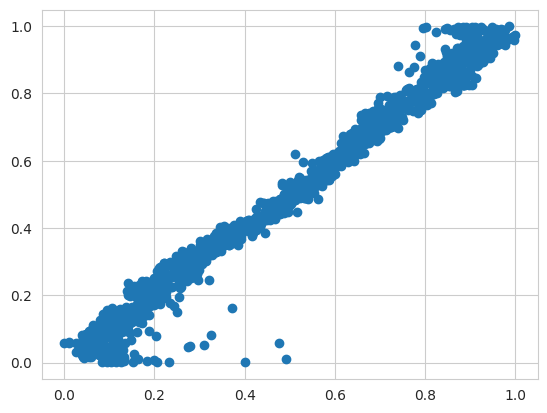

In [13]:
plt.figure()
plt.scatter(pts_diffmap[:, 0], pts[:, 0])

In [241]:
weights = weights / np.sqrt(weights.sum())
n = pts.shape[0]
num_acceptances = 0
const_in = generation.const_conversion(const, alpha, d, true_volume=True)
lls = []

u_index = np.random.randint(n)
x_u2 = np.random.uniform(size=1)
a_prob = fitting.acceptance_prob(A, weights, alpha, const_in, pts, u_index, x_u2)



In [243]:
a_prob.shape

(1500,)

In [245]:
np.arange(2000)[np.random.randint(n)]

35

In [253]:
weights

array([1.01645683, 7.01031457, 1.26122323, ..., 3.23281141, 1.08036674,
       1.69265171])

In [227]:
import tqdm

def mcmc_girg(A, weights, alpha, d, const, pts, n_steps=1000):
    n = pts.shape[0]
    num_acceptances = 0
    const_in = generation.const_conversion(const, alpha, d, true_volume=True)
    lls = []
    for _ in tqdm.tqdm(range(n_steps)):
        u_index = np.random.randint(n)
        x_u2 = np.random.uniform(size=1)
        accepted = fitting.acceptance_prob(A, weights, alpha, const_in, pts, u_index, x_u2)
        if accepted:
            lls.append(girg_loglikelihood(A, generation.get_probs(weights / np.sqrt(weights.sum()), pts, alpha, const_in)))
            num_acceptances += 1
            # print(f'{u_index}')

    return pts, lls, num_acceptances

In [228]:
pts_init = points.PointsTorus2(np.random.uniform(size=(n, d)))
pts_init2 = pts_init.copy()

pts_final, lls, num_acceptances = mcmc_girg(A, weights, alpha, d, const, pts_init, n_steps=20)

100%|██████████| 20/20 [00:03<00:00,  5.80it/s]


In [229]:
lls

[PointsTorus2(-903617.56095811),
 PointsTorus2(-903328.081093),
 PointsTorus2(-902999.23514528),
 PointsTorus2(-902844.9464741),
 PointsTorus2(-902729.40745499),
 PointsTorus2(-902586.44617774),
 PointsTorus2(-902415.52671104),
 PointsTorus2(-902358.00082185)]

In [213]:
pts_final[46]

PointsTorus2([0.91005611])

In [220]:
const_in = generation.const_conversion(const, alpha, d, true_volume=True)
fitting.girg_loglikelihood(A, generation.get_probs(weights, pts_init, alpha, const_in))
fitting.girg_loglikelihood(A, generation.get_probs(weights, pts, alpha, const_in))

PointsTorus2(-33832656.4560028)

PointsTorus2(-33832656.4560028)

In [221]:
pts
pts_init

PointsTorus2([[0.53379394],
              [0.28952514],
              [0.18260039],
              ...,
              [0.6101247 ],
              [0.37984138],
              [0.18430433]])

PointsTorus2([[0.3564775 ],
              [0.82364137],
              [0.85052508],
              ...,
              [0.48323176],
              [0.87092524],
              [0.68243028]])

In [219]:
pts_init

PointsTorus2([[0.3564775 ],
              [0.82364137],
              [0.85052508],
              ...,
              [0.48323176],
              [0.87092524],
              [0.68243028]])

In [191]:
n = pts_init.shape[0]
num_acceptances = 0
const_in = generation.const_conversion(const, alpha, d, true_volume=True)
lls = []

u_index = np.random.randint(n)
x_u2 = np.random.uniform(size=1)

# n = pts.shape[0]
eps = 1e-7
p_u_to_v = generation.get_probs_u(weights / np.sqrt(weights.sum()), pts, alpha, const_in, u_index)
x_u = pts[u_index].copy()
pts[u_index] = x_u2
p_u_to_v2 = generation.get_probs_u(weights / np.sqrt(weights.sum()), pts, alpha, const_in, u_index)
p_u_to_v2 = np.clip(p_u_to_v2, eps, 1 - eps)

mask = np.ones(n, dtype=bool)
mask[u_index] = False
log_Q_u = A[u_index, mask] * np.log(p_u_to_v[mask]) + (1 - A[u_index, mask]) * np.log(1 - p_u_to_v[mask])
log_Q_u2 = A[u_index, mask] * np.log(p_u_to_v2[mask]) + (1 - A[u_index, mask]) * np.log(1 - p_u_to_v2[mask])

Q_ratio = np.exp(log_Q_u2.sum() - log_Q_u.sum())
acceptance_prob = np.minimum(1, Q_ratio)

p = np.random.uniform()
accepted = acceptance_prob > p
if not accepted:
    pts[u_index] = x_u

../benji_girgs/generation.py:78: RuntimeWarning: divide by zero encountered in true_divide
  p_uv = np.divide(wuwv, dists**d)
/scratch/tmp.17453491.bdayan/ipykernel_57362/519760232.py:19: RuntimeWarning: divide by zero encountered in log
  log_Q_u = A[u_index, mask] * np.log(p_u_to_v[mask]) + (1 - A[u_index, mask]) * np.log(1 - p_u_to_v[mask])
/scratch/tmp.17453491.bdayan/ipykernel_57362/519760232.py:19: RuntimeWarning: invalid value encountered in multiply
  log_Q_u = A[u_index, mask] * np.log(p_u_to_v[mask]) + (1 - A[u_index, mask]) * np.log(1 - p_u_to_v[mask])


In [193]:
log_Q_u.sum()
log_Q_u2.sum()

PointsTorus2(nan)

PointsTorus2(-269.64158705)

In [194]:
np.argwhere(np.isnan(log_Q_u))

array([[  48],
       [  68],
       [ 193],
       [ 263],
       [ 328],
       [ 417],
       [ 461],
       [ 524],
       [ 583],
       [ 586],
       [ 617],
       [ 733],
       [ 801],
       [ 850],
       [1119],
       [1238],
       [1266],
       [1303],
       [1472]])

In [195]:
log_Q_u[47:53]

PointsTorus2([-0.00310993,         nan, -0.00098024, -0.00634206,
              -0.00520093, -0.00265187])

In [196]:
p_u_to_v[47:53]

PointsTorus2([3.10510320e-03, 1.00000000e+00, 9.79761955e-04,
              6.32198984e-03, 5.18743058e-03, 2.64836109e-03])

In [230]:
%timeit np.ones(10000)

5.5 µs ± 200 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [233]:
%time np.ones(10000)

CPU times: user 57 µs, sys: 2 µs, total: 59 µs
Wall time: 63.4 µs


array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
    # TODO remoe this code it all doesn't work
    # def run_pool(self, n_steps, plot=False):
    #     for _ in range(n_steps):
    #         self.pool.apply_async(self.step2)
    #     self.pool.close()
    #     self.pool.join()
    #     if plot:
    #         ax = plt.gca()
    #         fig = plt.gcf()
    #         ax.clear()
    #         ax.plot(self.ll_steps, self.lls)
    #         ax.set_title(f'n_steps: {self.num_steps} / {n_steps}, num_acceptances: {self.num_acceptances}')
    #
    # # TODO temporary addition to see if works with pool?
    # def __getstate__(self):
    #     self_dict = self.__dict__.copy()
    #     del self_dict['pool']
    #     return self_dict
    #
    # def __setstate__(self, state):
    #     self.__dict__.update(state)